## Time-Domain Star-Shaped PML for Wave Scattering

This notebook demonstrates a **frequency-dependent, star-shaped PML** implementation in NGSolve for solving time-domain scattering problems.


In [1]:
from netgen.geom2d import *
from nonlin_arnoldis import *
import numpy as np
from time import sleep, time
from netgen.occ import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from fem1d import geo1d 
from ngsolve import *
from ngsolve.webgui import Draw
import scipy as sc


maxh = 0.2   #mesh-size
maxh_1d = 0.15   #mesh-size for 1d mesh
order =  2     #fem order in interior domain
order_1d = 3   #fem order for 1d radial coordinate
L = 0.5        #length of radial part


center = (0,0)    #center of circle
center2 = (+0.0,0.0) #center of inner circle
R = 1           #radius of circle
R2 = 0.45            #radius of inner circle#

#params for sigma
alpha =10.0
gamma =0.0

m = (0,0)



In [2]:
#create geometry
circle = Circle(center, R).Face()
circle.edges.name = 'Gamma'
circle.faces.name = 'inner'

circle2 = Circle(center2, R2).Face()
circle2.edges.name = 'inner_boundary'

rect = MoveTo(-0.5,-0.5).Rectangle(1,1).Face()
rect.edges.name = "Gamma"
rect.faces.name = "inner"

rect2 = MoveTo(-0.4,-0.4).Rectangle(0.8,0.8).Face()

#choose geometry
#geo = OCCGeometry(circle-circle2, dim=2)
#geo = OCCGeometry(circle, dim=2)
geo = OCCGeometry(rect, dim=2)
#geo = OCCGeometry(rect-circle2, dim=2)
#geo= OCCGeometry(rect-rect2, dim=2)

#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh)

n = specialcf.normal(2) 
v = CoefficientFunction((x-m[0],y-m[1]))          

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [3]:
mesh1d = Mesh(geo1d(0,L).GenerateMesh(maxh=maxh_1d))
fes1d = H1(mesh1d,order=order_1d,complex=True)
N = fes1d.ndof

u,u_ = fes1d.TnT()

fem1d_mass_surf = np.array(BilinearForm(u*u_*ds('left')).Assemble().mat.ToDense())

fem1d_mass = np.array(BilinearForm(u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_x = np.array(BilinearForm(x*u*u_*dx).Assemble().mat.ToDense())
fem1d_mass_xx = np.array(BilinearForm(x*x*u*u_*dx).Assemble().mat.ToDense())

fem1d_drift = np.array(BilinearForm(grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_x = np.array(BilinearForm(x*grad(u)*u_*dx).Assemble().mat.ToDense())
fem1d_drift_xx = np.array(BilinearForm(x*x*grad(u)*u_*dx).Assemble().mat.ToDense())

fem1d_laplace = np.array(BilinearForm(grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_x = np.array(BilinearForm(x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())
fem1d_laplace_xx = np.array(BilinearForm(x*x*grad(u)*grad(u_)*dx).Assemble().mat.ToDense())

f = exp(-5**2*((x+0.2)*(x+0.3)+y*y))

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


Introducing 6 auxiliar functions allows a formulation without any unwanted fractions of i omega and which is amenable to a retranformation into the time domain.

This approach transforms the frequency-domain PML system into a **first-order system** without unwanted frequency-dependent coefficients, suitable for a time stepping algorithm in the time-domain.|

In [4]:
Gamma = mesh.Boundaries('Gamma')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)
fes_aux = ProductSpace(*( (N)*[fes_surf]))          
fes = ProductSpace(fes_int,*( (N-1)*[fes_surf]))
fes_prod = ProductSpace(fes, *(6*[fes_aux]), fes_int)     

ds_g = ds(definedon=Gamma)

trial = fes_prod.TrialFunction()
test = fes_prod.TestFunction()

p,q = trial[0], test[0]
h1, h2, h3, h4, h5, h6, h7  = trial[1], trial[2], trial[3], trial[4], trial[5], trial[6], trial[7]
g1, g2, g3, g4, g5, g6, g7  =  test[1], test[2], test[3], test[4], test[5], test[6], test[7]
p_int,q_int = p[0],q[0]

In [5]:
W0_form =(
         #interior
         grad(p_int)*grad(q_int)*dx
         -h7*g7*dx

         #exterior
         +sum(fem1d_laplace[i,j]*1/(n*v)*p[j]*q[i]*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_laplace[i,j])>0)
         -sum(fem1d_laplace[i,j]*1/(n*v)*(h6[j])*q[i]*ds_g                                
           for i in range(N) for j in range(N) if abs(fem1d_laplace[i,j])>0)
           
         +sum(fem1d_laplace_x[i,j]*2/(n*v)*p[j]*q[i]*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_laplace_x[i,j])>0)
         +sum(fem1d_laplace_xx[i,j]*1/(n*v)*p[j]*q[i]*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_laplace_xx[i,j])>0)
         +sum(fem1d_laplace_xx[i,j]*1/(n*v)*h1[j]*q[i]*ds_g                                  
           for i in range(N) for j in range(N) if abs(fem1d_laplace_xx[i,j])>0)

         -sum(fem1d_mass[i,j]*1/(4*n*v)*p[j]*q[i]*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         -sum(fem1d_mass[i,j]*1/(4*n*v)*h1[j]*q[i]*ds_g                                        
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)

         -sum(fem1d_drift[i,j]*1/(n*v)*v*p[i].Trace().Deriv()*q[j]*ds_g                    
           for i in range(N) for j in range(N) if abs(fem1d_drift[i,j])>0)
         -sum(fem1d_drift_x[i,j]*1/(n*v)*v*p[i].Trace().Deriv()*q[j]*ds_g 
            for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0) 
         -sum(fem1d_drift_x[i,j]*1/(n*v)*v*h1[i].Trace().Deriv()*q[j]*ds_g                         
           for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)

         -sum(fem1d_drift[i,j]*1/(n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g             
           for i in range(N) for j in range(N) if abs(fem1d_drift[i,j])>0)          
         -sum(fem1d_drift_x[i,j]*1/(n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g               
            for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)
         -sum(fem1d_drift_x[i,j]*1/(n*v)*h1[j]*v*q[i].Trace().Deriv()*ds_g                       
           for i in range(N) for j in range(N) if abs(fem1d_drift_x[i,j])>0)
         
         -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j].Trace().Deriv()*q[i]*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         -sum(fem1d_mass[i,j]*1/(2*n*v)*v*p[j]*q[i].Trace().Deriv()*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         -sum(fem1d_mass[i,j]*1/(2*n*v)*v*h1[j].Trace().Deriv()*q[i]*ds_g              
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         -sum(fem1d_mass[i,j]*1/(2*n*v)*v*h1[j]*q[i].Trace().Deriv()*ds_g          
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)

         +sum(fem1d_mass[i,j]*(v*v)/(n*v)*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g 
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         +sum(fem1d_mass[i,j]*(v*v)/(n*v)*h1[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g            
           for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         
         -sum(fem1d_mass_surf[i,j]*1/(2*n*v)*p[j]*q[i]*ds_g   
           for i in range(N) for j in range(N) if abs(fem1d_mass_surf[i,j])>0)

          + sum(fem1d_mass[i,j]*(gamma*h1[j]-alpha*p[j])*g1[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          - sum(fem1d_mass[i,j]*h5[j]*g5[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          - sum(fem1d_mass[i,j]*h2[j]*g2[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*(gamma*h3[j]-alpha*h2[j])*g3[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*(gamma*h4[j]-alpha*h3[j])*g4[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          +sum(fem1d_mass[i,j]*((gamma+alpha)*h6[j]-alpha*p[j])*g6[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
)

W1_form =(#interior
          h7 * q_int * dx
          +p_int * g7 * dx

         #exterior
         +sum(fem1d_mass[i,j]*(n*v)*h5[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
         +sum(fem1d_mass[i,j]*(n*v)*h2[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)

         + sum(fem1d_mass_x[i,j]*2*(n*v)*h5[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)
         +sum(fem1d_mass_x[i,j]*4*(n*v)*h2[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)
         +sum(fem1d_mass_x[i,j]*2*(n*v)*h3[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_x[i,j])>0)

         +sum(fem1d_mass_xx[i,j]*(n*v)*h5[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)
         +sum(fem1d_mass_xx[i,j]*3*(n*v)*h2[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)
         +sum(fem1d_mass_xx[i,j]*3*(n*v)*h3[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)
         +sum(fem1d_mass_xx[i,j]*(n*v)*h4[j]*q[i]*ds_g
            for i in range(N) for j in range(N) if abs(fem1d_mass_xx[i,j])>0)
            
          + sum(fem1d_mass[i,j]*(h1[j])*g1[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*p[j]*g5[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*h1[j]*g2[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*h3[j]*g3[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*h4[j]*g4[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
          + sum(fem1d_mass[i,j]*h6[j]*g6[i]*ds_g
                for i in range(N) for j in range(N) if abs(fem1d_mass[i,j])>0)
            )

In [6]:
# W0_EV = BilinearForm(W0_form).Assemble()
# W1 = BilinearForm(1j*W1_form).Assemble()                        
# W1_EV = BilinearForm(-1j*W1_form).Assemble()                    

In [7]:
print(fes_prod.ndof)

4260


In [8]:
# gf = GridFunction(fes_prod,multidim=40)
# shift = 0.3-9.5j    #shift for Arnoldi algorithm
# #lam = array(ArnoldiSolver(W0.mat,W1.mat,freedofs=fes.FreeDofs(),vecs=list(gf.vecs),shift=shift))
# lam = array(PolyArnoldiSolver([W0_EV.mat, W1_EV.mat],shift,200,nevals=100,inversetype='umfpack',freedofs=fes_prod.FreeDofs()))
# #lam, _ = sc.linalg.eig(W0_EV.mat.ToDense(), W1.mat.ToDense())

Now, we solve the time-domain scattering problem using the **Crank-Nicolson scheme**:

The energy plot shows constant energy during initial wave propagation, followed by decay as waves are absorbed by the PML layer. The vertical line marks the theoretical arrival time at the PML boundary.

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

Inverse done in 0.069 seconds


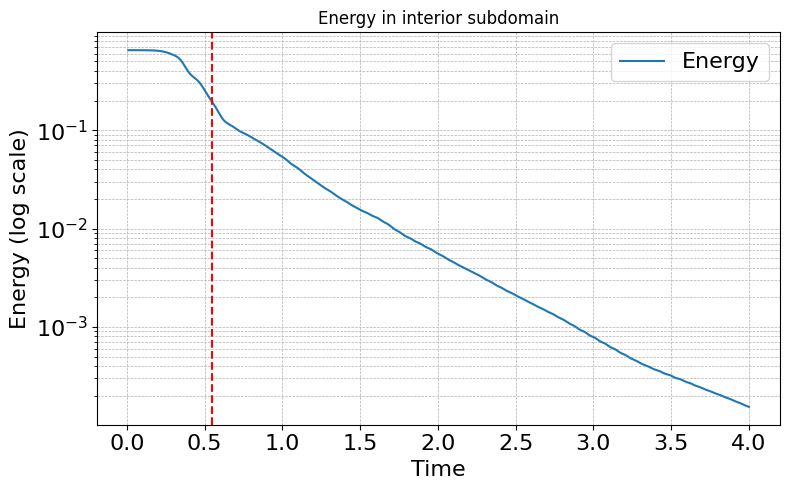

In [9]:
tau = 0.01          # time-step
tend = 4            # end time

A = 0.5      # height
s = 0.05     # width
u0 = A * exp(-((x)**2 + (y)**2)/(2*s**2))       # initial condition

def crank_nickelson(u0, W1_form, W0_form):
    #print(type(u0))
    gfu = GridFunction(fes_prod)
    gfu.components[0].components[0].Set(u0)

    scene = Draw(gfu.components[0].components[0],
                 deformation=False, min= -0.05, max=0.2)

    M1 = BilinearForm(W1_form + 0.5*tau*W0_form).Assemble().mat
    M2 = BilinearForm(W1_form - 0.5*tau*W0_form).Assemble().mat

    t0 = time()
    M1_inv = M1.Inverse(fes_prod.FreeDofs(), inverse="umfpack")
    t1 = time()
    print(f"Inverse done in {t1 - t0:.3f} seconds")
    energy = []
    time_list = []
    gfus = GridFunction(fes, multidim = 0)
    gfu_old = GridFunction(fes_int)
    gfu_t = gfu.components[7]
    norm = []
    for i in range(int(tend/tau)):
        gfu_old.Set(gfu.components[0].components[0])
        gfu.vec.data = M1_inv * (M2 * gfu.vec)
        gfus.AddMultiDimComponent(gfu.components[0].components[0].vec.data)

        e = abs(Integrate(gfu_t**2, mesh)) + abs(Integrate(grad(gfu.components[0].components[0])**2, mesh) )
        norm.append(sqrt(abs(Integrate(gfu.components[0].components[0]**2,mesh)))+sqrt(abs(Integrate(grad(gfu.components[0].components[0])**2, mesh))))
        energy.append(e)
        time_list.append((i+1)*tau)
        scene.Redraw()
        #sleep(0.1)
   
    plt.figure(figsize=(8,5))
    plt.semilogy(time_list, energy, label="Energy")
    plt.axvline(x=0.55, color='red', linestyle='--')
    plt.xlabel("Time", fontsize=16)
    plt.ylabel("Energy (log scale)", fontsize=16)
    plt.title("Energy in interior subdomain")
    plt.legend(fontsize=16)
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.show()

    # plot H1-norm of solution in interior domain

    # plt.figure(figsize=(8,5))
    # plt.semilogy(time_list, norm, label="H1-Norm")
    # plt.axvline(x=0.55, color='red', linestyle='--')
    # plt.xlabel("Time", fontsize=16)
    # plt.ylabel("H1-Norm (log scale)", fontsize=16)
    # plt.title("H1-Norm of solution in interior subdomain")
    # plt.legend(fontsize=16)
    # plt.grid(True, which="both", ls="--", lw=0.5)
    # plt.tick_params(axis='both', which='major', labelsize=16)
    # plt.tight_layout()
    # plt.show()

    return energy, time_list
_ =crank_nickelson(u0=u0, W1_form=W1_form,W0_form=W0_form)

